In [25]:
from pymongo import MongoClient

In [65]:
import matplotlib.pyplot as plt

In [26]:
# Connection URL
connection_url = "mongodb://localhost:27017/"
client = MongoClient(connection_url)

In [28]:
db = client['tmdb_db']
collection = db['movies']

Notar que nuestra colección de películas guarda 3 tipos de objeto:
* Película
* Género
* Actor

In [56]:
collection.distinct('type')

['actor', 'genre']

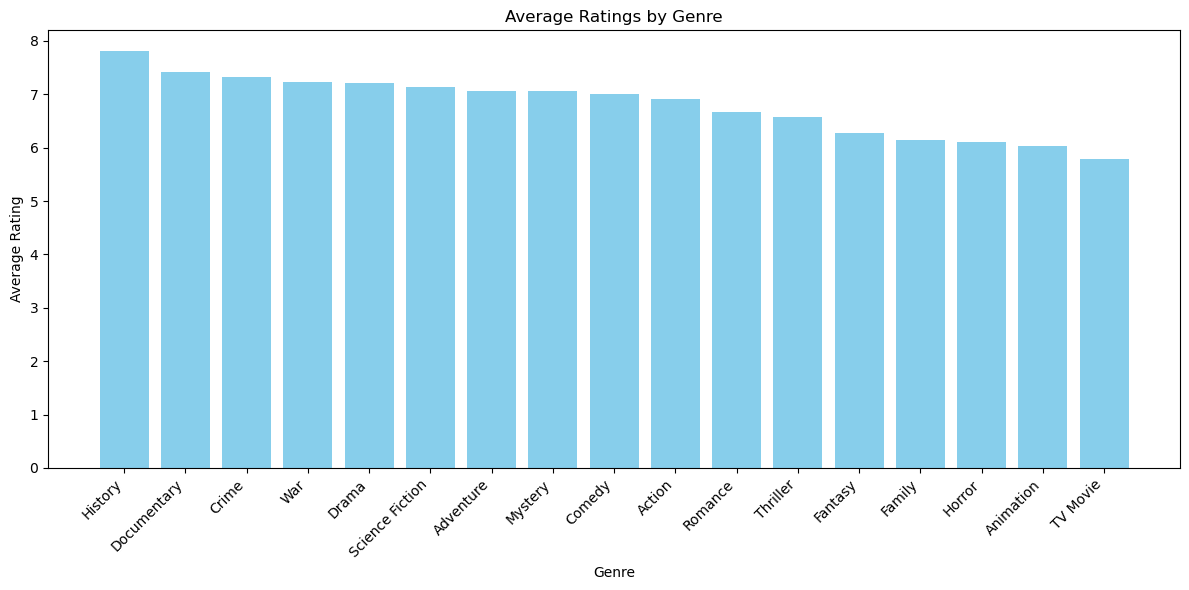

In [67]:
pipeline = [
    {"$match": {"type": {"$exists": False}}}, 
    
    {"$lookup": {
        "from": "movies", 
        "localField": "genre_ids",
        "foreignField": "id",
        "as": "genre_details"
    }},
    
    {"$unwind": "$genre_details"},

    {"$match": {"genre_details.type": "genre"}},  

    {"$unwind": "$genre_ids"},
    
    {"$match": {"$expr": {"$eq": ["$genre_ids", "$genre_details.id"]}}},

    {"$group": {
        "_id": "$genre_details.name",
        "AverageRating": {"$avg": "$vote_average"}
    }},
    
    {"$sort": {"AverageRating": -1}}
]

# Execute the aggregation pipeline
average_ratings_by_genre = list(collection.aggregate(pipeline))

# Extract the genres and their average ratings
genres = [genre['_id'] for genre in average_ratings_by_genre]
average_ratings = [genre['AverageRating'] for genre in average_ratings_by_genre]

plt.figure(figsize=(12, 6))
plt.bar(genres, average_ratings, color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.title('Average Ratings by Genre')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




In [57]:
pipeline = [
    {"$match": {
        "type": {"$exists": False} 
    }},
    
    {"$group": {
        "_id": "$title",
        "document": {"$first": "$$ROOT"},
        "maxPopularity": {"$max": "$popularity"}
    }},
    
    {"$sort": {"maxPopularity": -1}},
    
    {"$limit": 5},
    
    {"$replaceRoot": {"newRoot": "$document"}},
    
    {"$lookup": {
        "from": "movies",  
        "localField": "genre_ids",
        "foreignField": "id",
        "as": "genre_details"
    }},
    
    {"$lookup": {
        "from": "movies",
        "localField": "actor_ids",
        "foreignField": "id",
        "as": "actor_details"
    }},
    
    {"$project": {
        "title": 1,
        "popularity": 1,
        "genres": "$genre_details.name",  
        "actors": "$actor_details.name"  
    }},
    
    {"$addFields": {
        "genres": {"$setUnion": ["$genres", []]}, 
        "actors": {"$setUnion": ["$actors", []]}  
    }}
]

top_movies = collection.aggregate(pipeline)

# Print the results
print("Las 5 películas más populares con sus actores y géneros:\n")
for movie in top_movies:
    print(f"Title: {movie['title']}, Popularity: {movie['popularity']}")
    print(f"Genres: {', '.join(movie['genres'])}")
    print(f"Actors: {', '.join(movie['actors'])}")
    print("-" * 60)

Las 5 películas más populares con sus actores y géneros:

Title: Kingdom of the Planet of the Apes, Popularity: 3629.389
Genres: Action, Adventure, Science Fiction
Actors: Anastasia Miller, Andy McPhee, Benjamin Scott, Dichen Lachman, Dmitriy Miller, Eka Darville, Frances Berry, Freya Allan, Kaden Hartcher, Karin Konoval, Kevin Durand, Lydia Peckham, Markus Hamilton, Michael Spudic, Neil Sandilands, Nina Gallas, Nirish Bhat Surambadka, Olga Miller, Owen Teague, Peter Hayes, Peter Macon, Ras-Samuel Welda'abzgi, Samuel Falé, Sara Wiseman, Sheree da Costa, Souleymane Diasse, Travis Jeffery, Virginie Laverdure, William H. Macy
------------------------------------------------------------
Title: Godzilla x Kong: The New Empire, Popularity: 3148.883
Genres: Action, Adventure, Science Fiction
Actors: Alex Ferns, Anthony Brandon Wong, Brian Tyree Henry, Cassie Riley, Chantelle Jamieson, Chika Ikogwe, Dan Stevens, Fala Chen, Greg Hatton, Jamaliah Othman, Jordy Campbell, Kaylee Hottle, Kevin Cope

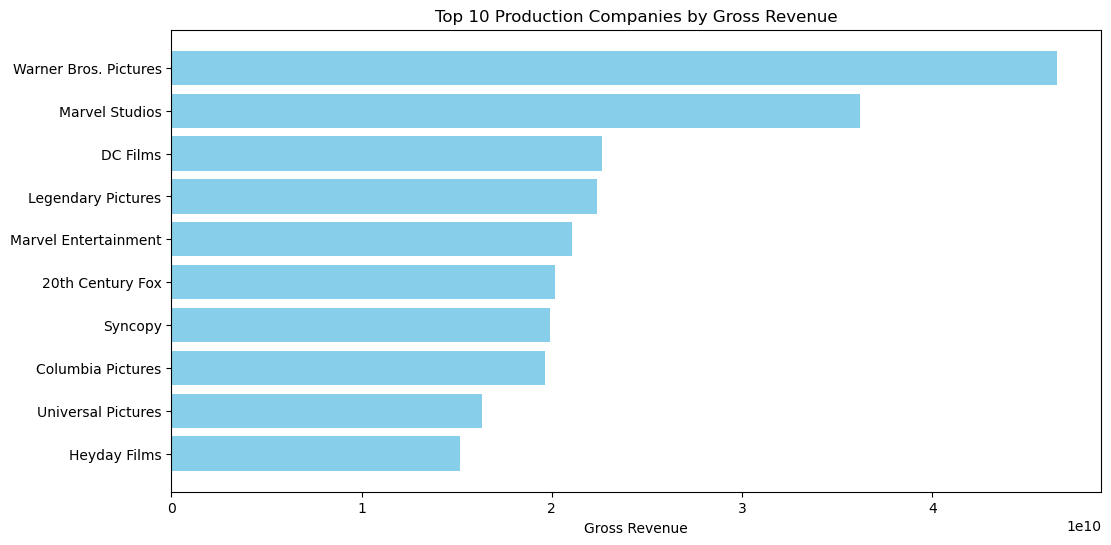

In [66]:
pipeline = [
    {"$unwind": "$production_companies"},  
    {"$group": {
        "_id": "$production_companies.name",
        "gross_revenue": {"$sum": "$revenue"} 
    }},
    {"$sort": {"gross_revenue": -1}},  
    {"$limit": 10},  
    {"$project": {
        "production_company": "$_id",
        "gross_revenue": 1  
    }}
]

# Execute the aggregation pipeline
top_10_companies_by_revenue = list(db.movies.aggregate(pipeline))

# Extract the production company names and gross revenues
production_companies = [company['production_company'] for company in top_10_companies_by_revenue]
gross_revenues = [company['gross_revenue'] for company in top_10_companies_by_revenue]

# Plot using matplotlib
plt.figure(figsize=(12, 6))
plt.barh(production_companies, gross_revenues, color='skyblue')
plt.xlabel('Gross Revenue')
plt.title('Top 10 Production Companies by Gross Revenue')
plt.gca().invert_yaxis()  # To display the highest revenue company at the top
plt.show()


Genre: Adventure, Average Budget: 124910833.33333333
Genre: Science Fiction, Average Budget: 103486378.73754153
Genre: Action, Average Budget: 95736386.76844783
Genre: Comedy, Average Budget: 76793814.43298969
Genre: Crime, Average Budget: 75821621.62162162
Genre: Fantasy, Average Budget: 73901041.66666667
Genre: Family, Average Budget: 57166666.666666664
Genre: History, Average Budget: 53954545.45454545
Genre: Thriller, Average Budget: 53038495.57522124
Genre: Animation, Average Budget: 49000000.0
Genre: War, Average Budget: 45000000.0
Genre: Drama, Average Budget: 44871410.88700565
Genre: Mystery, Average Budget: 33890376.29113924
Genre: Horror, Average Budget: 16478350.515463918
Genre: Romance, Average Budget: 15714285.714285715
Genre: TV Movie, Average Budget: 0.0
Genre: Documentary, Average Budget: 0.0


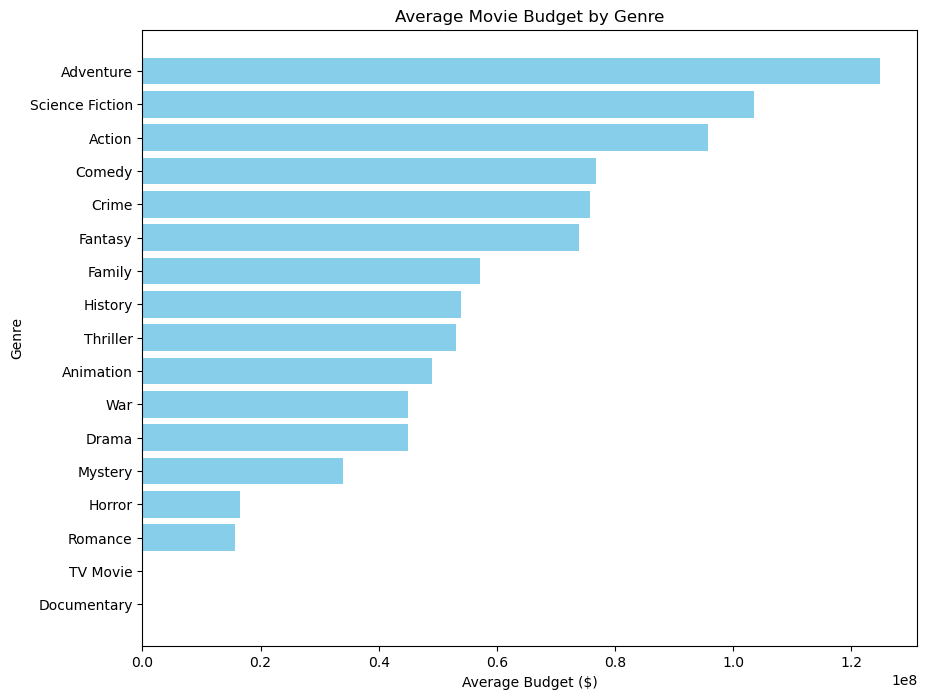

In [68]:
import matplotlib.pyplot as plt

# Assuming db is already connected and configured
pipeline = [
    {"$unwind": "$genres"},
    {"$group": {
        "_id": "$genres.name",
        "average_budget": {"$avg": "$budget"}
    }},
    {"$sort": {"average_budget": -1}}
]
average_budget_by_genre = db.movies.aggregate(pipeline)

# Prepare data for plotting
genres = []
average_budgets = []
for genre in average_budget_by_genre:
    genres.append(genre['_id'])
    average_budgets.append(genre['average_budget'])
    print(f"Genre: {genre['_id']}, Average Budget: {genre['average_budget']}")

# Plotting the data
plt.figure(figsize=(10, 8))
plt.barh(genres, average_budgets, color='skyblue')
plt.xlabel('Average Budget ($)')
plt.ylabel('Genre')
plt.title('Average Movie Budget by Genre')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest budgets at the top
plt.show()


In [ ]:
pipeline = [
    {"$match": {"type": {"$exists": False}}}, 
    
    {"$lookup": {
        "from": "movies", 
        "localField": "genre_ids",
        "foreignField": "id",
        "as": "genre_details"
    }},
    
    {"$unwind": "$genre_details"},

    {"$match": {"genre_details.type": "genre"}},  

    {"$unwind": "$genre_ids"},
    
    {"$match": {"$expr": {"$eq": ["$genre_ids", "$genre_details.id"]}}},

    {"$group": {
        "_id": "$genre_details.name",
        "AverageRating": {"$avg": "$vote_average"}
    }},
    
    {"$sort": {"AverageRating": -1}}
]

In [ ]:
pipeline = [
    {"$match": {
        "type": {"$exists": False} 
    }},
    
    {"$group": {
        "_id": "$title",
        "document": {"$first": "$$ROOT"},
        "maxPopularity": {"$max": "$popularity"}
    }},
    
    {"$sort": {"maxPopularity": -1}},
    
    {"$limit": 5},
    
    {"$replaceRoot": {"newRoot": "$document"}},
    
    {"$lookup": {
        "from": "movies",  
        "localField": "genre_ids",
        "foreignField": "id",
        "as": "genre_details"
    }},
    
    {"$lookup": {
        "from": "movies",
        "localField": "actor_ids",
        "foreignField": "id",
        "as": "actor_details"
    }},
    
    {"$project": {
        "title": 1,
        "popularity": 1,
        "genres": "$genre_details.name",  
        "actors": "$actor_details.name"  
    }},
    
    {"$addFields": {
        "genres": {"$setUnion": ["$genres", []]}, 
        "actors": {"$setUnion": ["$actors", []]}  
    }}
]

In [ ]:
pipeline = [
    {"$unwind": "$production_companies"},  
    {"$group": {
        "_id": "$production_companies.name",
        "gross_revenue": {"$sum": "$revenue"} 
    }},
    {"$sort": {"gross_revenue": -1}},  
    {"$limit": 10},  
    {"$project": {
        "production_company": "$_id",
        "gross_revenue": 1  
    }}
]

In [ ]:
pipeline = [
    {"$unwind": "$genres"},
    {"$group": {
        "_id": "$genres.name",
        "average_budget": {"$avg": "$budget"}
    }},
    {"$sort": {"average_budget": -1}}
]

In [69]:
titulo = "Dune"  

pipeline = [
    {"$match": {"title": {"$regex": titulo, "$options": "i"}}},

    {"$lookup": {
        "from": "movies", 
        "localField": "genre_ids",
        "foreignField": "id",
        "as": "genre_details"
    }},
    
    {"$lookup": {
        "from": "movies",  
        "localField": "actor_ids",
        "foreignField": "id",
        "as": "actor_details"
    }},
    
    {"$project": {
        "title": 1,
        "release_date": 1,
        "genres": "$genre_details.name",
        "actors": "$actor_details.name",
        "overview": 1
    }},
    
    {"$unwind": "$genres"},
    {"$unwind": "$actors"},

    {"$group": {
        "_id": {
            "title": "$title",
            "release_date": "$release_date",
            "overview": "$overview"
        },
        "unique_genres": {"$addToSet": "$genres"},
        "unique_actors": {"$addToSet": "$actors"}
    }},
    
    {"$project": {
        "_id": 0,
        "title": "$_id.title",
        "release_date": "$_id.release_date",
        "overview": "$_id.overview",
        "genres": "$unique_genres",
        "actors": "$unique_actors"
    }}
]

# Execute the aggregation pipeline
movie_details = db.movies.aggregate(pipeline)

# Print the results
print(f"Película '{titulo}':")
for movie in movie_details:
    print(f"Title: {movie['title']}")
    print(f"Release Date: {movie['release_date']}")
    print(f"Overview: {movie['overview']}")
    print("Genres: " + ", ".join(movie['genres']))
    print("Actors: " + ", ".join(movie['actors']))
    print("-" * 60)


Película 'Dune':
Title: Dune: Part Two
Release Date: 2024-02-27
Overview: Follow the mythic journey of Paul Atreides as he unites with Chani and the Fremen while on a path of revenge against the conspirators who destroyed his family. Facing a choice between the love of his life and the fate of the known universe, Paul endeavors to prevent a terrible future only he can foresee.
Genres: Adventure, Science Fiction
Actors: Dave Bautista, Abdelkarim Hussein Seli Mohamed Hassanin, Xavier Alba Royo, Affif Ben Badra, Tedroy Newell, Josh Brolin, Rachid Abbad, Tony Cook, Oxa Hazel, Ana Cilas, Rebecca Ferguson, Amra Mallassi, Hassan Najib, Kajsa Mohammar, Tim Hilborne, Peter Sztojanov Jr., Hamza Sayd, Zdeněk Dvořáček, Alan Mehdizadeh, Kathy Owen, Omar A.K., Adam Bloom, Timothée Chalamet, Stellan Skarsgård, Alison Adnet, Hopi Grace, Dylan Baldwin, Mohamed Mouraoui, Kincsö Pethö, Paul Boyle, Gábor Szemán, Jonathan Gunning, Zsófia Kocsis, Souheila Yacoub, Kait Tenison, Billy Clements, Giusi Merli, M

In [17]:
# Close the connection to MongoDB
client.close()